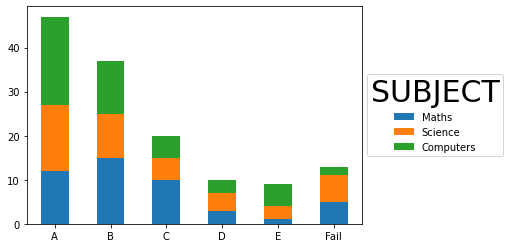

In [1]:
# Import libraries

import matplotlib.pyplot as plt
import pandas as pd

# Define Data

df = pd.DataFrame({
    'Maths': [12, 15, 10, 3, 1, 5],
    'Science': [15, 10, 5, 4, 3, 6],
    'Computers':[20, 12, 5, 3, 5, 2]
})

labels = ['A','B','C','D','E','Fail']

# Plot bar chart

ax = df.plot(stacked=True, kind='bar')
   
# Set Tick labels

ax.set_xticklabels(labels,rotation='horizontal')

ax.legend(title='SUBJECT',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))

# Display chart


plt.show()